In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPool2D, Dense, GlobalAveragePooling2D
from keras.models import load_model

In [6]:
def conv3x3(filters, stride=1):
    return Conv2D(filters, kernel_size=(3,3), strides=stride, padding='same', use_bias=False)

def residual_block(x, filters, downsample=False):
    shortcut = x
    stride = 1
    if downsample:
        stride = 2
        shortcut = Conv2D(filters, kernel_size=(1,1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = conv3x3(filters, stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv3x3(filters)(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet10(input_shape=(224,224,3), num_classes=1000):
    inputs = Input(shape=input_shape)
    
    x = conv3x3(64, stride=2)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)
    
    x = GlobalAveragePooling2D()(x)

    x = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, x)
    return model

# Define function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load image
    img = load_img(image_path, target_size=(64, 64))
    # Convert image to array
    img_arr = img_to_array(img)
    # Normalize pixel values
    img_arr = img_arr / 255.0
    # Return preprocessed image
    return img_arr



In [7]:
# Define paths to image directory and label csv file
image_dir = 'Cell_Data/Cell_Images/cells'
label_file = 'Cell_Data/label.csv'

# Load label csv file
labels_df = pd.read_csv(label_file)

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop over each row in the label csv file and extract image path and label
for index, row in labels_df.iterrows():
    image_name = row['image_name']
    label = row['label']
    image_path = os.path.join(image_dir, image_name)
    image_paths.append(image_path)
    labels.append(label)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into training and testing sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)














# # train_images_file = 'train_images.npy'
# # test_images_file = 'test_images.npy'

# # # Check if preprocessed images already exist and load them if they do
# # if os.path.exists(train_images_file):
# #     train_images = np.load(train_images_file)
# #     test_images = np.load(test_images_file)
# # else:
# #     # Split data into training and testing sets
# #     train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [8]:
# Load and preprocess training images
train_images = []
for image_path in train_image_paths:
    img = load_and_preprocess_image(image_path)
    train_images.append(img)
train_images = np.array(train_images)

# Load and preprocess testing images
test_images = []
for image_path in test_image_paths:
    img = load_and_preprocess_image(image_path)
    test_images.append(img)
test_images = np.array(test_images)

In [9]:
# # Save preprocessed images as numpy arrays
# np.save('train_images.npy', train_images)
# np.save('test_images.npy', test_images)
# np.save('train_labels.npy', train_labels)
# np.save('test_labels.npy', test_labels)


In [10]:
# train_images = np.load('train_images.npy')
# test_images = np.load('test_images.npy')

In [11]:
model = ResNet10(input_shape=(64, 64, 3), num_classes=7)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()

In [13]:
# Define some callbacks
early_stop = EarlyStopping(patience=3, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stop, checkpointer])

Epoch 1/5
1269/1269 [==============================] - 510s 400ms/step - loss: 0.6736 - accuracy: 0.7465 - val_loss: 0.7062 - val_accuracy: 0.7393
Epoch 2/5
1269/1269 [==============================] - 499s 393ms/step - loss: 0.3551 - accuracy: 0.8708 - val_loss: 0.4747 - val_accuracy: 0.8220
Epoch 3/5
1269/1269 [==============================] - 510s 402ms/step - loss: 0.2981 - accuracy: 0.8910 - val_loss: 0.4333 - val_accuracy: 0.8465
Epoch 4/5
1269/1269 [==============================] - 477s 376ms/step - loss: 0.2546 - accuracy: 0.9071 - val_loss: 0.8034 - val_accuracy: 0.7697
Epoch 5/5
1269/1269 [==============================] - 480s 379ms/step - loss: 0.2279 - accuracy: 0.9178 - val_loss: 0.7975 - val_accuracy: 0.7616


In [14]:
# from matplotlib import pyplot as plt

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [15]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)










# best_model = load_model('best_model.h5')

# # Evaluate the model on the testing set
# test_loss, test_accuracy = best_model.evaluate(test_generator)
# print('Test loss:', test_loss)
# print('Test accuracy:', test_accuracy)

397/397 [==============================] - 28s 71ms/step - loss: 0.7696 - accuracy: 0.7608
Test accuracy: 0.7608164548873901


In [16]:
best_model = load_model('best_model.h5')

# Evaluate the model on the testing set
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

397/397 [==============================] - 27s 67ms/step - loss: 0.4325 - accuracy: 0.8514
Test loss: 0.4324866235256195
Test accuracy: 0.8513673543930054


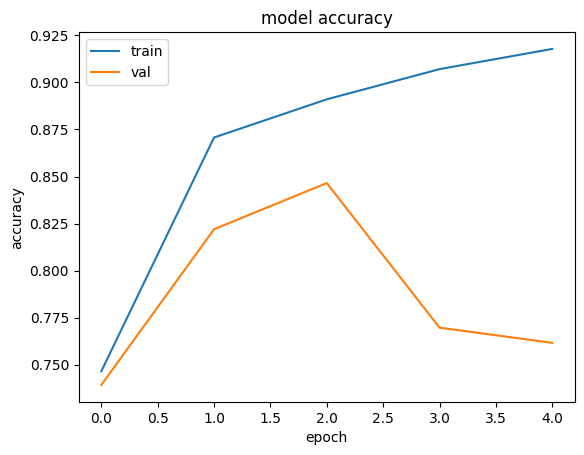

In [17]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

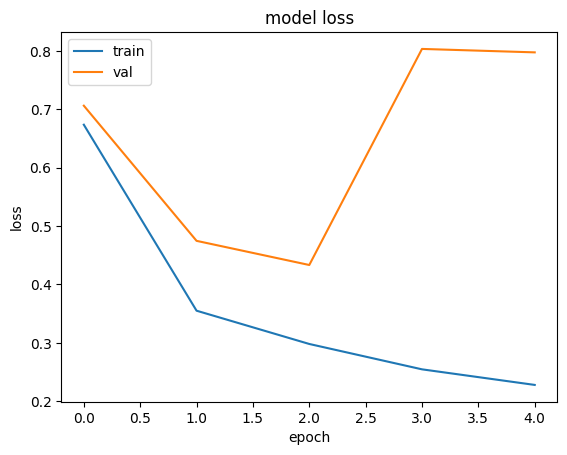

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
result = model.predict(test_images,)
y_test = np.argmax(result, axis=1)


397/397 [==============================] - 26s 64ms/step


In [20]:
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are the true and predicted labels, respectively
y_true = test_labels
y_pred = y_test

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[2547   18  226   32    2   35]
 [ 787 1025  610  417    5   30]
 [  71    5 2369  102    2  137]
 [   1    1   73 2666    0    4]
 [  74    0  184    5  589  155]
 [   9    0   31   16    3  458]]


In [21]:
# Loop over the rows and columns of the confusion matrix to extract TP, TN, FP, and FN numbers for each class
for i in range(len(cm)):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - tp - fp - fn
    
    print(f"Class {i+1}")
    print("True Positives (TP): ", tp)
    print("True Negatives (TN): ", tn)
    print("False Positives (FP): ", fp)
    print("False Negatives (FN): ", fn)

Class 1
True Positives (TP):  2547
True Negatives (TN):  8887
False Positives (FP):  942
False Negatives (FN):  313
Class 2
True Positives (TP):  1025
True Negatives (TN):  9791
False Positives (FP):  24
False Negatives (FN):  1849
Class 3
True Positives (TP):  2369
True Negatives (TN):  8879
False Positives (FP):  1124
False Negatives (FN):  317
Class 4
True Positives (TP):  2666
True Negatives (TN):  9372
False Positives (FP):  572
False Negatives (FN):  79
Class 5
True Positives (TP):  589
True Negatives (TN):  11670
False Positives (FP):  12
False Negatives (FN):  418
Class 6
True Positives (TP):  458
True Negatives (TN):  11811
False Positives (FP):  361
False Negatives (FN):  59
